In [1]:
import psycopg2
from configobj import ConfigObj
import sys
import os
import gdal
import json
import datetime
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
import json

In [2]:
cfg = ConfigObj("sites/bavaria.site")

with open('cfg/bands.json') as data_file:
    bandcfg = json.load(data_file)
    
conn = psycopg2.connect('postgres://{}:{}@{}/{}'.format(os.environ["POSTGIS_USER"],os.environ["POSTGIS_PASSWORD"],cfg['dbhost'],cfg['dbase']))

In [131]:
from patchfactory import queryDates
import pylab
from pylab import imshow, show, get_cmap
import pandas as pd

def queryRaster(conn,rastertable,tiletable, tileid, date, rtype, level, bands, verbose=False):
    curs=conn.cursor()
    # convert band names to band numbers using config file

    sql="""
        select
            ST_astiff(ST_UNION(ST_CLIP(r.rast, t.geom)),ARRAY{bands})
        from
            {rastertable} r, {tiletable} t
        where
            t.id={tileid} and
            ST_INTERSECTS(r.rast,t.geom) and
            r.type='{rtype}' and
            r.level='{level}' and
            date='{date}'
        """.format(rastertable=rastertable,
        tiletable=tiletable,
        tileid=tileid,
        rtype=rtype,
        level=level,
        date=date.strftime("%Y-%m-%d"),
        bands=bands)

    if verbose: print sql
    # following https://gis.stackexchange.com/questions/130139/downloading-raster-data-into-python-from-postgis-using-psycopg2

    # Use a virtual memory file, which is named like this
    vsipath = '/vsimem/from_postgis'

    # Download raster data into Python as GeoTIFF, and make a virtual file for GDAL
    curs.execute(sql)
    gdal.FileFromMemBuffer(vsipath, bytes(curs.fetchone()[0]))

    # Read first band of raster with GDAL
    ds = gdal.Open(vsipath)
    arrays=[]
    for b in range(len(bands)):
        band = ds.GetRasterBand(b+1)
        arrays.append(band.ReadAsArray())

    # Close and clean up virtual memory file
    ds = band = None
    gdal.Unlink(vsipath)
    curs.close()

    return np.stack(arrays,axis=2)

def buff2rast(buff):
    # Use a virtual memory file, which is named like this
    vsipath = '/vsimem/from_postgis'
    
    gdal.FileFromMemBuffer(vsipath, bytes(buff))

    # Read first band of raster with GDAL
    ds = gdal.Open(vsipath)
    band=ds.GetRasterBand(1)
    
    gdal.Unlink(vsipath)
    return band.ReadAsArray()

def queryLabel(conn,tiletable, tileid, verbose=False):
    curs=conn.cursor()
    # convert band names to band numbers using config file

    
    sql="""
    select st_astiff(
    st_clip(
    st_union(
        st_asraster(st_intersection(t.geom,l.geom), 
            10::float,10::float,st_xmin(t.geom)::float, st_xmax(t.geom)::float,'8BUI',l.labelid,-9999)
    ),
    t.geom, -9999)
    )
    from {tiletable} t, fields l 
    where t.id={tileid} and ST_Intersects(t.geom, l.geom)
    group by t.geom
    
    """.format(tileid=tileid, tiletable=tiletable)
    
    if verbose: print sql
    # following https://gis.stackexchange.com/questions/130139/downloading-raster-data-into-python-from-postgis-using-psycopg2

    # Download raster data into Python as GeoTIFF, and make a virtual file for GDAL
    curs.execute(sql)
    rs = curs.fetchone()[0]
    
    arr = buff2rast(rs)
        
    # Close and clean up virtual memory file

    curs.close()

    return arr

def drawlabels(conn,tiletable,tileid):
    
    labelmap = pd.read_sql('select distinct labelid, label from labelmap where labelid is not null order by labelid', conn)
    def id2name(labelmap,labelid):
        return labelmap.loc[labelmap["labelid"]==labelid]["label"].values[0]
    
    fig, ax = plt.subplots()
    arr = queryLabel(conn,tiletable,tileid)
    im = ax.imshow(np.flipud(arr), cmap=get_cmap("Spectral"), interpolation='none')
    ax.set_title("Labels")
    uniques=np.unique(arr)
    
    cbar=fig.colorbar(im, ax=ax )
    cbar.set_ticks(uniques)
    cbar.set_ticklabels([id2name(labelmap,t) for t in uniques])
    
def plot(tileid,date,level):
    print date
    
    def m(rtype):

        def toidx(bands):
            return[bandcfg[level][rtype].index(b)+1 for b in bands]

        allbands=bandcfg[level][rtype]
        return queryRaster(conn,rastertable,tiletable, tileid, date, rtype, level, toidx(allbands)),allbands

    arr,bands = m("10m")

    fig,axs=plt.subplots(1,4,figsize=(14,10))
    i=0
    for ax in axs.reshape(-1):
        ax.imshow(arr[:,:,i],interpolation='none')
        ax.set_title(bands[i])
        i+=1

    arr,bands = m("20m")
    fig,axs=plt.subplots(2,3,figsize=(10,6))
    i=0
    for ax in axs.reshape(-1):
        ax.imshow(arr[:,:,i],interpolation='none')
        ax.set_title(bands[i])
        i+=1

    arr,bands = m("60m")
    fig,axs=plt.subplots(1,3,figsize=(9,6))
    i=0
    for ax in axs.reshape(-1):
        ax.imshow(arr[:,:,i],cmap=pylab.gray(),interpolation='none')
        ax.set_title(bands[i])
        i+=1

from ipywidgets import Layout
def drawmap(tileid):

    sql="""
    select
        ST_asgeojson(ST_Transform(t.geom,4326)), 
        ST_asgeojson(ST_Transform(st_collect(st_intersection(t.geom,l.geom)),4326))
    from {} t, fields l 
    where t.id={} and st_intersects(t.geom, l.geom)
    group by t.geom
    """.format(tiletable,tileid)
    
    cur=conn.cursor()
    cur.execute(sql)
    tile,feat = cur.fetchone()
    tilegeojson = json.loads(tile)
    featgeojson = json.loads(feat)
    cur.close()

    lon,lat = tilegeojson["coordinates"][0][0]
    center = [lat,lon]
    zoom = 15

    tilelayer = GeoJSON(data=tilegeojson)
    featlayer = GeoJSON(data=featgeojson)

    m = Map(center=center, zoom=zoom,layout=Layout(width='50%', height='300px'))

    #m.add_layer(tilelayer)
    m.add_layer(featlayer)
    
    return m

2016-05-02


Map(center=[48.4026379223398, 11.3493876915707], layers=(TileLayer(options=[u'opacity', u'attribution', u'max_zoom', u'detect_retina', u'min_zoom', u'tile_size']), GeoJSON(data={u'type': u'MultiPolygon', u'coordinates': [[[[11.3495238770873, 48.4055932286414], [11.3494397716958, 48.4037681485049], [11.3490239000066, 48.4036425999843], [11.3489218000066, 48.4036208999844], [11.3488717000066, 48.4037990999843], [11.3486410000066, 48.4041587999843], [11.3480777000066, 48.4048033999844], [11.3472248000065, 48.4057399999844], [11.3471275000065, 48.4058930999844], [11.3489758000066, 48.4055992999843], [11.3495238770873, 48.4055932286414]]], [[[11.348220913597, 48.4026617534499], [11.3477173109311, 48.4026720357295], [11.3478267000066, 48.4028011999844], [11.348220913597, 48.4026617534499]]], [[[11.3434225788104, 48.4070784028981], [11.3451597011319, 48.4070429915862], [11.3451187000065, 48.4069893999845], [11.3453873000065, 48.4061552999845], [11.3455436000065, 48.4058753999845], [11.3455575000065, 48.4058505999845], [11.3469911000065, 48.4058736999844], [11.3470916000065, 48.4056892999844], [11.3479222000066, 48.4047498999844], [11.3487353000066, 48.4038297999843], [11.3488065000066, 48.4036383999843], [11.3487404000066, 48.4036393999843], [11.3477692000066, 48.4037473999844], [11.3472751000065, 48.4037555999844], [11.3471403000065, 48.4038357999844], [11.3460423000065, 48.4040710999845], [11.3451432000065, 48.4041351999845], [11.3443872000065, 48.4035589999845], [11.3444062000065, 48.4032701999845], [11.3444090000065, 48.4032271999845], [11.344441268933, 48.4027388702278], [11.3429077978138, 48.4027701224467], [11.3430781680368, 48.4064774001281], [11.3434551000065, 48.4070186999846], [11.3434225788104, 48.4070784028981]]], [[[11.345749765945, 48.4027121868027], [11.344441268933, 48.4027388702278], [11.3444090000065, 48.4032271999845], [11.3453283000065, 48.4032377999845], [11.3456187000065, 48.4032397999845], [11.345749765945, 48.4027121868027]]], [[[11.3431033559809, 48.4070254289626], [11.3431060871568, 48.4070848517642], [11.3434225788104, 48.4070784028981], [11.3434551000065, 48.4070186999846], [11.3431033559809, 48.4070254289626]]], [[[11.3495296717251, 48.4057189650762], [11.3495238770873, 48.4055932286414], [11.3489758000066, 48.4055992999843], [11.3471275000065, 48.4058930999844], [11.3472005000065, 48.4059372999844], [11.3481607000066, 48.4058233999844], [11.3489225000066, 48.4057146999843], [11.3493811000066, 48.4057182999843], [11.3495296717251, 48.4057189650762]]], [[[11.3486195000066, 48.4027969999843], [11.3487072000066, 48.4030145999843], [11.3487617000066, 48.4033498999843], [11.3487404000066, 48.4036393999843], [11.3488065000066, 48.4036383999843], [11.3488394000066, 48.4034602999843], [11.3488099000066, 48.4032270999844], [11.3487567000066, 48.4030291999843], [11.3486195000066, 48.4027969999843]]], [[[11.3486892000066, 48.4027035999843], [11.3488318000066, 48.4029970999843], [11.3489310000066, 48.4032748999843], [11.3489417000066, 48.4034974999843], [11.3489218000066, 48.4036208999844], [11.3490239000066, 48.4036425999843], [11.3490231000066, 48.4034877999843], [11.3489578000066, 48.4031997999843], [11.3487221000066, 48.4026641999844], [11.3486892000066, 48.4027035999843]]], [[[11.3430781680368, 48.4064774001281], [11.3431033559809, 48.4070254289626], [11.3434551000065, 48.4070186999846], [11.3430781680368, 48.4064774001281]]], [[[11.3455436000065, 48.4058753999845], [11.3469388000065, 48.4059022999844], [11.3469911000065, 48.4058736999844], [11.3455575000065, 48.4058505999845], [11.3455436000065, 48.4058753999845]]], [[[11.3464864305338, 48.4070159284544], [11.3465294771286, 48.4070150501169], [11.3466399000065, 48.4067650999844], [11.3468759000065, 48.4062077999844], [11.3470100000065, 48.4059069999844], [11.3469388000065, 48.4059022999844], [11.3468411000065, 48.4060956999844], [11.3467204000065, 48.4063929999844], [11.3464864305338, 48.4070159284544]]], [[[11.3494407537555, 48.4037894601737], [11.34938769157

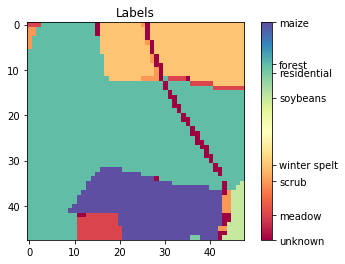

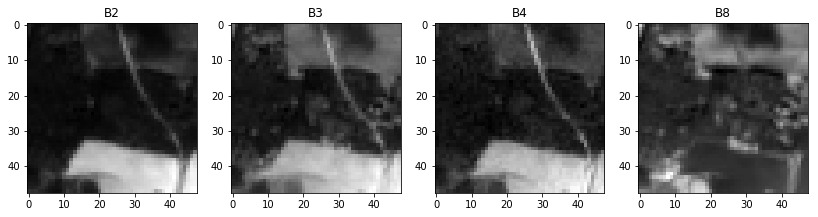

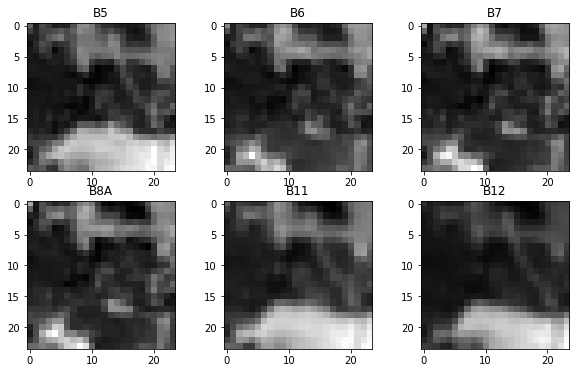

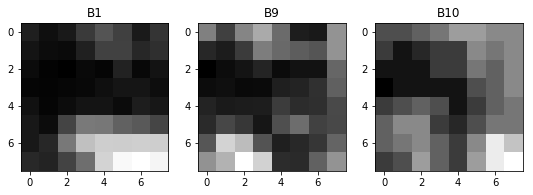

In [135]:
dates = queryDates(conn,"bavaria")["date"].sort_values().values

level='L1C'
rastertable="bavaria"
tiletable="tiles480"

tileid=7000

drawlabels(conn, tiletable, tileid)

plot(tileid,dates[10],level)

drawmap(tileid)

IndexError: index 0 is out of bounds for axis 0 with size 0

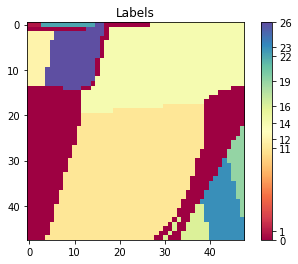

In [114]:
level='L1C'
rastertable="bavaria"
tiletable="tiles480"
tileid=6001

drawlabels(conn,tiletable,tileid)

raster ST_AsRaster(geometry geom, double precision scalex, double precision scaley, double precision gridx, double precision gridy, text pixeltype, double precision value=1, double precision nodataval=0, double precision skewx=0, double precision skewy=0, boolean touched=false);

In [7]:


sql="""
select st_astiff(
    st_tile(
    st_clip(
    st_union(
        st_asraster(st_intersection(t.geom,l.geom), 
            10::float,10::float,st_xmin(t.geom)::float, st_xmax(t.geom)::float,'32BUI',l.code,-9999)
    ),
    t.geom, -9999),
    48,48, True
    )
    )
    from tiles480 t, osm l 
    where t.id=6604 and ST_Intersects(t.geom, l.geom)
    group by t.geom
    """


curs=conn.cursor()
curs.execute(sql)
#a = curs.fetchall()
buff = curs.fetchone()

In [8]:
vsipath = '/vsimem/from_postgis'
gdal.FileFromMemBuffer(vsipath, bytes(buff[0]))

# Read first band of raster with GDAL
ds = gdal.Open(vsipath)

band=ds.GetRasterBand(1)
print ds.GetGeoTransform()
gdal.Unlink(vsipath)
arr = band.ReadAsArray()

(671470.0, 10.0, 0.0, 5382670.0, 0.0, 10.0)


In [128]:
labelmap

,labelid,label
0,1,sugar beet
1,2,summer oat
2,3,meadow
3,4,farm
4,5,rape
5,6,vegetable
6,7,scrub
7,8,hop
8,9,winter spelt
9,10,water


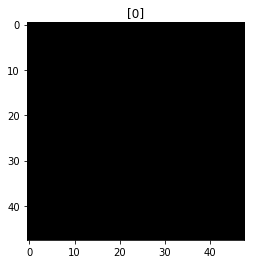

In [10]:
plt.imshow(np.flipud(arr))
plt.title(np.unique(arr))

In [96]:
u = np.unique(arr)
arr[u[0]]=0 for unique in uniquevalues

SyntaxError: invalid syntax (<ipython-input-96-c7d707435140>, line 2)

In [115]:
labelmap = pd.read_sql('select distinct labelid, label from labelmap where labelid is not null order by labelid', conn)

In [117]:
labelmap

,labelid,label
0,1,sugar beet
1,2,summer oat
2,3,meadow
3,4,farm
4,5,rape
5,6,vegetable
6,7,scrub
7,8,hop
8,9,winter spelt
9,10,water


In [107]:
labelmap.shape

(27, 2)